# Diabetes Risk Prediction - Modelling

In this notebook we'll build a model with a high recall score and save it.

# 📚 Import Libraries

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.float_format', lambda x:'%.3f' % x)
import warnings
warnings.simplefilter(action="ignore", category=Warning)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sb
# Configure default settings for plots
sb.set(style='ticks')
sb.set_palette('Paired')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
# Data Processing Librariies
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## Algorithms
# Ensemble Methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Non-linear Methods
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Performance Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

# Save model
import pickle

# 📖 Load Data

In [19]:
raw_data = pd.read_csv('../Data/Processed/data_no_duplicates.csv')
raw_data.shape

(251, 17)

In [20]:
# Creating a copy of the dataframe in case we need the raw data in the next sections
df = raw_data.copy()

# 🧹 Data Preparation

## Handling Outliers

In [4]:
df[df['Age'] >= 80]

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
101,85,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,Positive
102,90,Female,No,Yes,Yes,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,Positive
185,85,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,Positive
186,90,Female,No,Yes,Yes,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,Positive


In [21]:
df = df[df['Age'] < 80]
df.reset_index(inplace=True, drop=True)
df.shape

(249, 17)

In [6]:
df['class'].value_counts()

Positive    316
Negative    200
Name: class, dtype: int64

In [28]:
df.to_csv('../Data/Processed/data_no_outlier.csv', index=False)

## Transform Data

In [22]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)
        
print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

# Creating the features list by removing the label
cat_features = cat_cols[:-1]

Categorical columns: 16 ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
Numeric columns: 1 ['Age']


In [23]:
# Encoding target
lbl_encoder = LabelEncoder()
df['class Encoded'] = lbl_encoder.fit_transform(df['class'])
df['class Encoded'].value_counts()

1    171
0     78
Name: class Encoded, dtype: int64

In [24]:
x = df.drop(['class', 'class Encoded'], axis=1)
y = df['class Encoded']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [25]:
y_test.value_counts()

1    34
0    16
Name: class Encoded, dtype: int64

In [26]:
# Define transformers for different column types
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine transformers for specific columns
preprocessor = ColumnTransformer([
    ("num", numerical_transformer, num_cols),
    ("cat", categorical_transformer, cat_features)
])

# Fit transformers on training data only
preprocessor.fit(x_train)

# Transform train and test data using fitted transformers
x_train_transformed = preprocessor.transform(x_train)
x_test_transformed = preprocessor.transform(x_test)

x_train_transformed.shape

(199, 16)

In [29]:
# Save the preprocessor
with open('../Models/data_preprocessor.pkl', 'wb') as preprocessor_file:
    pickle.dump(preprocessor, preprocessor_file)

# 🤖 Model Building

## Comparing Different Algorithms

In this section we'll compare non-linear and ensemble algorithms using k-fold cross validation.

❗️ Prioritizing the **maximization of Recall over Precision** might be a better choice for this problem as the the cost of false negatives is higher than the cost of false positives.

$$Recall = \frac{TP}{(TP+FN)}$$

In [30]:
def model_evaluation(x, y, models):
    '''
        This function takes x, y and models and applies 
        k-fold cross validation to the each algorithm in 
        the models list by using x and y training set. 
        Displays the mean and standard deviation of 
        accuracy, precision, recall, f1 scores in tabular
        format and boxplots.

        ---
        ### Parameters
        - x <array>: Feature values.
        - y <array>: Target values.
        - models <list>: List of the model objects to be vealuated.
    '''
    
    names = []
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    
    # Create a dataframe to store the different metric values for each algorithm
    df_results = pd.DataFrame(columns=['Algorithm', 'Acc Mean', 'Acc STD', 'Pre Mean', 'Pre STD', 
                                       'Rec Mean', 'Rec STD', 'F1 Mean', 'F1 STD'])
    results_acc = [] # List of accuracy scores for each fold of each algorithm
    results_pre = [] # List of precision scores for each fold of each algorithm
    results_rec = [] # List of recall scores for each fold of each algorithm
    results_f1 = []  # List of F1 scores for each fold of each algorithm
    
    for name, model in models:
        names.append(name)
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)
        result = cross_validate(model, x, y, cv=kfold, scoring=scoring)
    
        # Mean and standard deviation of Accuracy scores for the algorithm
        acc_mean = result['test_accuracy'].mean()
        acc_std = result['test_accuracy'].std()

        # Mean and standard deviation of Precision scores for the algorithm
        pre_mean = result['test_precision'].mean()
        pre_std = result['test_precision'].std()

        # Mean and standard deviation of Recall scores for the algorithm
        rec_mean = result['test_recall'].mean()
        rec_std = result['test_recall'].std()

        #Mean and standard deviation of F1-Score scores for the algorithm
        f1_mean = result['test_f1'].mean()
        f1_std = result['test_f1'].std()
        
        # Create the row of the results
        df_result_row = {'Algorithm': name, 'Acc Mean': acc_mean, 'Acc STD': acc_std, 'Pre Mean': pre_mean, 
                         'Pre STD': pre_std, 'Rec Mean': rec_mean, 'Rec STD': rec_std, 'F1 Mean': f1_mean, 
                         'F1 STD': f1_std}
        # Add the row to the results data frame
        df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
        
        results_acc.append(result['test_accuracy'])
        results_pre.append(result['test_precision'])
        results_rec.append(result['test_recall'])
        results_f1.append(result['test_f1'])

    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # Display the mean and standard deviation of all metrics for all algorithms
    print(df_results)
    
    # Display the overall results in a boxplot graph
    plot_objects = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
    fig, (ax1, ax2, ax3, ax4) = plot_objects
    
    ax1.boxplot(results_acc)
    ax1.set_title('Accuracy', fontsize=14)
    ax1.set_xticklabels(names, rotation=30)
    ax2.boxplot(results_pre)
    ax2.set_title('Precision', fontsize=14)
    ax2.set_xticklabels(names, rotation=30)
    ax3.boxplot(results_rec)
    ax3.set_title('Recall', fontsize=14)
    ax3.set_xticklabels(names, rotation=30)
    ax4.boxplot(results_f1)
    ax4.set_title('F1-Score', fontsize=14)
    ax4.set_xticklabels(names, rotation=30)
    plt.tight_layout()
    plt.show()

### Ensemble Methods

In [31]:
ens_models = []
ens_models.append(('RFC', RandomForestClassifier()))
ens_models.append(('ABC', AdaBoostClassifier()))
ens_models.append(('GBC', GradientBoostingClassifier()))

           Acc Mean  Acc STD  Pre Mean  Pre STD  Rec Mean  Rec STD  F1 Mean  \
Algorithm                                                                     
RFC           0.914    0.064     0.954    0.071     0.927    0.057    0.938   
ABC           0.849    0.098     0.897    0.092     0.891    0.080    0.891   
GBC           0.884    0.071     0.923    0.071     0.913    0.055    0.916   

           F1 STD  
Algorithm          
RFC         0.045  
ABC         0.071  
GBC         0.050  


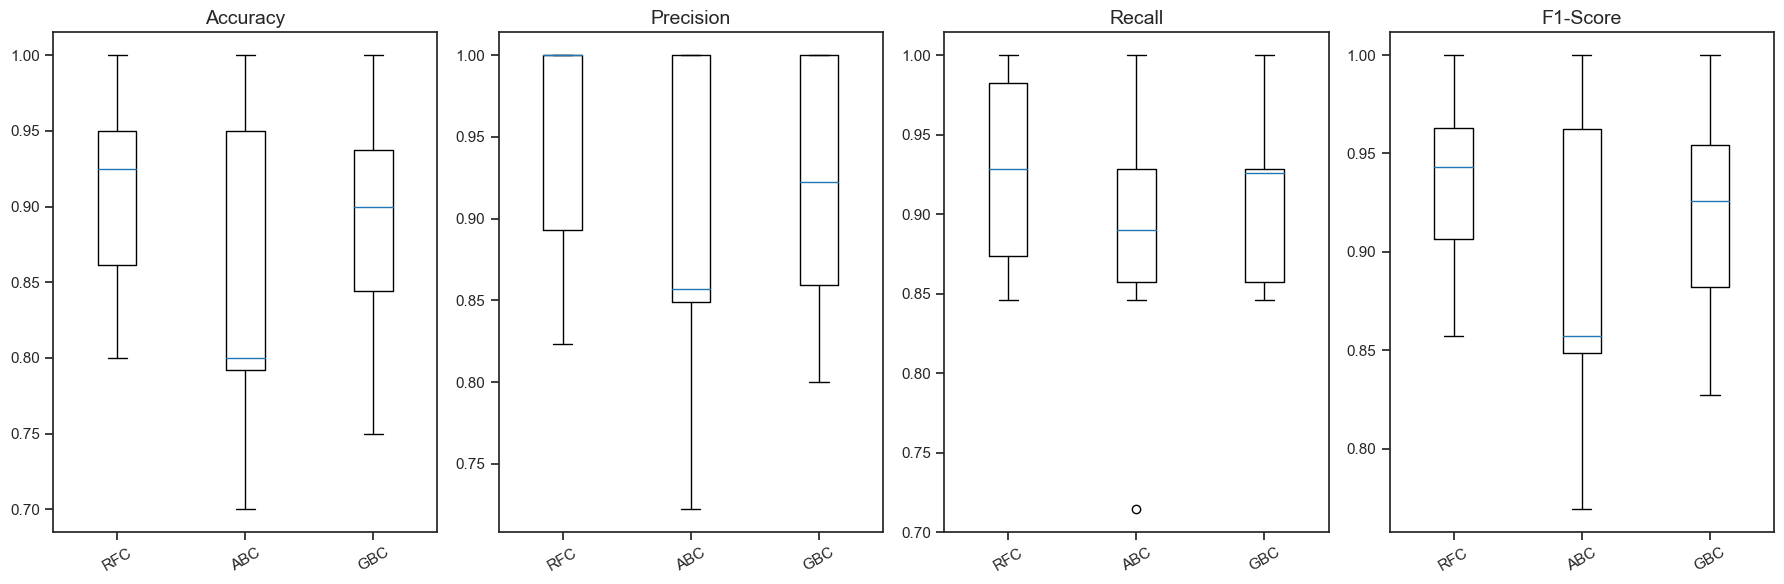

In [32]:
model_evaluation(x_train_transformed, y_train, ens_models)

🔎 **Observations:** RFC has the highest recall score among the others. However, before moving forward with the algorithm, we need to check non-linear methods as well.

### Non-linear Methods

In [33]:
nl_models = []
nl_models.append(('SVC', SVC()))
nl_models.append(('DTC', DecisionTreeClassifier()))
nl_models.append(('KNN', KNeighborsClassifier()))
nl_models.append(('GNB', GaussianNB()))
nl_models.append(('XGB', XGBClassifier()))

           Acc Mean  Acc STD  Pre Mean  Pre STD  Rec Mean  Rec STD  F1 Mean  \
Algorithm                                                                     
SVC           0.909    0.058     0.929    0.054     0.942    0.043    0.935   
DTC           0.879    0.077     0.940    0.054     0.883    0.101    0.907   
KNN           0.869    0.068     0.975    0.038     0.832    0.092    0.895   
GNB           0.879    0.068     0.924    0.078     0.905    0.034    0.913   
XGB           0.874    0.072     0.915    0.065     0.905    0.065    0.908   

           F1 STD  
Algorithm          
SVC         0.042  
DTC         0.062  
KNN         0.059  
GNB         0.047  
XGB         0.052  


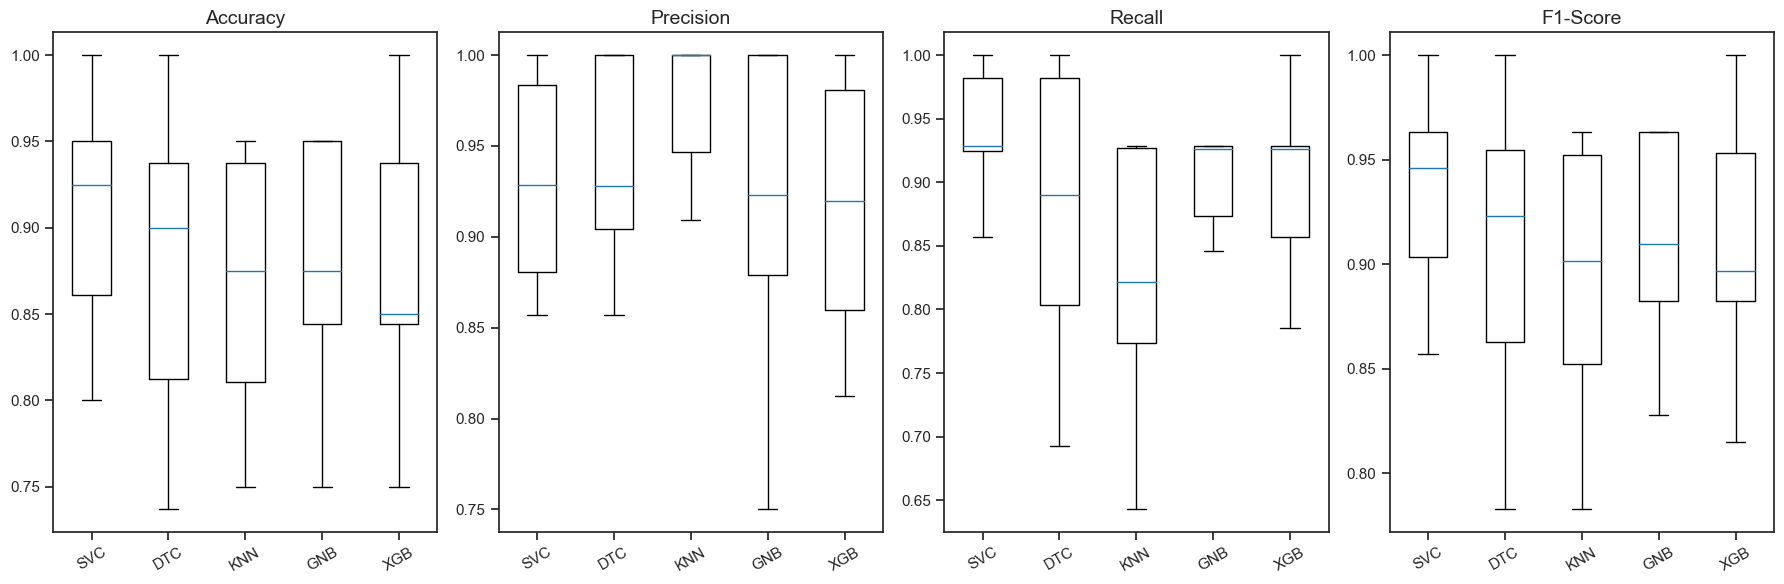

In [34]:
model_evaluation(x_train_transformed, y_train, nl_models)

🔎 **Observations:** SVC provides the best recall score among others. However, it's not better than RFC. We'll tune the hyper parameters for this method.

# 🏁 Finalizing Model

In [35]:
model_rfc = RandomForestClassifier()

crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

h_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    estimator = model_rfc,
    param_grid = h_params,
    scoring = 'recall', 
    n_jobs = -1,
    cv = crossvalidation
)

grid.fit(x_train_transformed, y_train)

# Print the best score and the hyper parameters that provides that score
grid.best_params_, grid.best_score_

({'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50},
 0.9637566137566138)

In [36]:
model = RandomForestClassifier(**grid.best_params_)
model.fit(x_train_transformed, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=50)

In [37]:
y_hat = model.predict(x_test_transformed)

In [38]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.94      0.94      0.94        34

    accuracy                           0.92        50
   macro avg       0.91      0.91      0.91        50
weighted avg       0.92      0.92      0.92        50



In [39]:
def plot_confusion_matrix(y_test, predictions):
    # Plot the confusion matrix
    cf_matrix = confusion_matrix(y_test, predictions)
    fig = plt.subplots(figsize=(10, 8))
    sb.set(font_scale=1.6)
    sb.heatmap(cf_matrix, annot=True)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

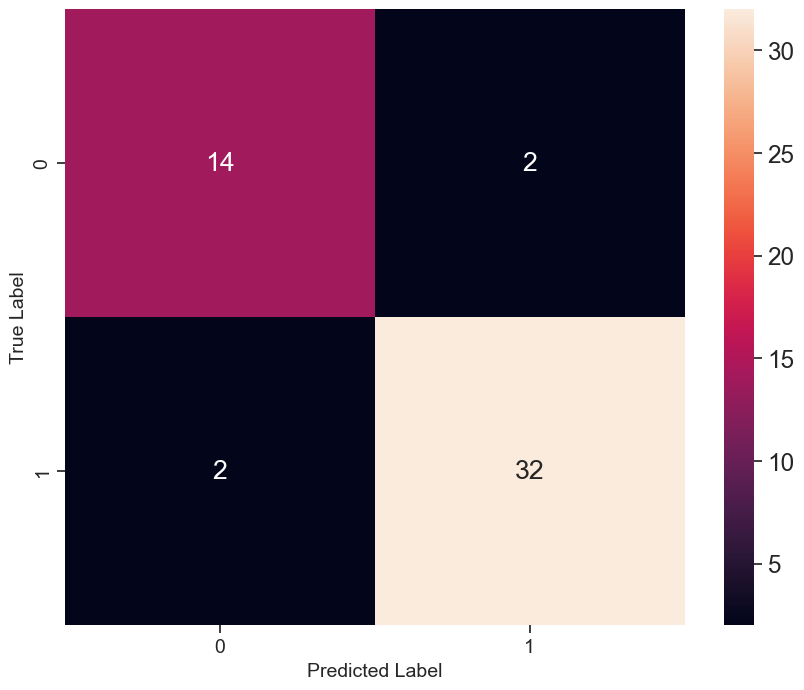

In [40]:
plot_confusion_matrix(y_test, y_hat)

In [41]:
def plot_roc_curve(y_test, predictions, estimator):
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=estimator)
    display.plot()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()

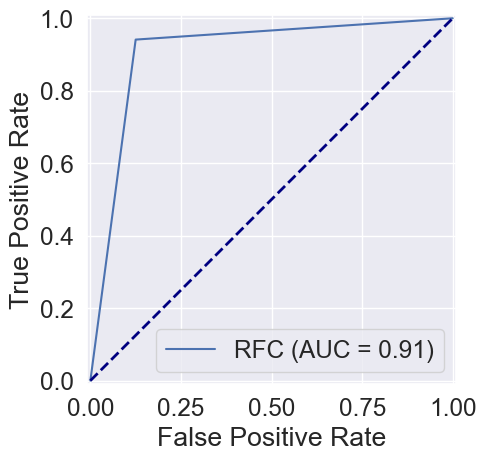

In [42]:
plot_roc_curve(y_test, y_hat, 'RFC')

🔎 **Observations:** RFC provides promissing results with a very low false negative rate.

# Future Work

- We can collect more data which would provide more robust results
- Or we can explore oversampling technique which will both increase the amount of the data and make a balanced dataset
- We can explore the impact of dimension reduction techniques

In [43]:
with open('../Models/model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)